Ocean Parcels: Script for Mixing, Advection and Sinking based on Jose's scripts

In [31]:
%matplotlib inline
import sys
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [32]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    path2 = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        path = os.path.join(path2, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
        if not os.path.exists(path):    
            raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [33]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking',
'home': '/home/vvalenzuela/MOAD/analysis-vicente/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/animations'}


In [34]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [35]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [36]:
#Definitions
start = datetime(2022, 8, 23) #Start date
length = 7 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 1 # 1000   # number of  locations
n = 500 # number of particles per location
dmin = 40#minimum depth
dd = 20 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

See if the particle is in the water or not

In [37]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(datetime(2022, 8, 23),path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [38]:
#Set deploy coordinates following yaml   
clat = [49.195045]
clon = [-123.301956]
#
a, b = finder(clat[0], clon[0])
print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
#
duration = timedelta(days=length)
#
x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)
#
lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

The total depth at this location is 85.375 m


In [39]:
#Set start date time and the name of the output file
# JUST ADVECTION
name_adv = 'Advection_'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_adv + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_adv = os.path.join(path['out'], fn)
#Set start date time and the name of the output file
# ADVECTION + MIXING
name_adv_mix = 'Advection_Mixing_'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_adv_mix + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_adv_mix = os.path.join(path['out'], fn)
#Set start date time and the name of the output file
#
name_sewage = 'Run_sewage_'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_sewage + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_sewage = os.path.join(path['out'], fn)
#
name_marine = 'Run_marine_'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_marine + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_marine = os.path.join(path['out'], fn)


In [40]:
local = 0

In [41]:
# Add diatoms, dinoflagelates and POC
aa = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/23aug22/SalishSea_1h_20220823_20220823_biol_T.nc')
aa

<xarray.Dataset> Size: 14GB
Dimensions:                       (y: 898, x: 398, nvertex: 4, deptht: 40,
                                   axis_nbounds: 2, time_counter: 24)
Coordinates:
    nav_lat                       (y, x) float32 1MB ...
    nav_lon                       (y, x) float32 1MB ...
  * deptht                        (deptht) float32 160B 0.5 1.5 ... 414.5 441.5
    time_centered                 (time_counter) datetime64[ns] 192B ...
  * time_counter                  (time_counter) datetime64[ns] 192B 2022-08-...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables: (12/16)
    bounds_lon                    (y, x, nvertex) float32 6MB ...
    bounds_lat                    (y, x, nvertex) float32 6MB ...
    area                          (y, x) float32 1MB ...
    deptht_bounds                 (deptht, axis_nbounds) float32 320B ...
    nitrate                       (time_counter, deptht, y, x) float32 1GB ...
    time_centered_bounds          (time_counter, axis_nbounds) datetime64[ns] 384B ...
    ...                            ...
    flagellates                   (time_counter, deptht, y, x) float32 1GB ...
    microzooplankton              (time_counter, deptht, y, x) float32 1GB ...
    dissolved_organic_nitrogen    (time_counter, deptht, y, x) float32 1GB ...
    particulate_organic_nitrogen  (time_counter, deptht, y, x) float32 1GB ...
    biogenic_silicon              (time_counter, deptht, y, x) float32 1GB ...
    mesozooplankton               (time_counter, deptht, y, x) float32 1GB ...
Attributes:
    name:         SalishSea_1h_20220821_20220825
    description:  biology
    title:        biology
    Conventions:  CF-1.6
    timeStamp:    2022-Dec-26 02:01:21 GMT
    uuid:         6bdbdddb-86cc-44c2-81a5-03159c4ee23c

Add diatoms, flagellates and Particles Organic Nitrogen (PON) for calculations/tuning of K_scav, K_adsorb and K_desorp.

In [42]:

#

varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol']
filenames,variables=filename_set(start,length,varlist)

#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)


#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Bth)
field_set.add_field(TD)

#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)

####BUILD Particle typeN######
class MPParticle(JITParticle):    
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0) 
    status = Variable('status', initial =  1) 

In [43]:
# Fieldest for PON :)
varlist=['PON', 'DIATO', 'FLAGE']
filenames, variables = filename_set(start, length, varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'deptht','time': 'time_counter'}
PON=Field.from_netcdf(filenames['PON'], variables['PON'], dimensions, allow_time_extrapolation=True, chunksize='auto')
DIATO=Field.from_netcdf(filenames['DIATO'], variables['DIATO'], dimensions, allow_time_extrapolation=True, chunksize='auto')
FLAGE=Field.from_netcdf(filenames['FLAGE'], variables['FLAGE'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#
field_set.add_field(PON)
field_set.add_field(DIATO)
field_set.add_field(FLAGE)

In [44]:
pset_adv = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset_adv_mix = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset_sewage = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))
pset_marine = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

ADVECTION KERNEL with 4th Order Runge Kutta method

In [45]:
def Advection(particle, fieldset, time): 
    aa = fieldset.particulate_organic_nitrogen[time, particle.depth, particle.lat, particle.lon]*1e8
    bb = fieldset.diatoms[time, particle.depth, particle.lat, particle.lon]*1e8
    cc = fieldset.flagellates[time, particle.depth, particle.lat, particle.lon]*1e8
    if particle.status == 1:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t) sea surface height
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt) sea surface height in the next time step
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth 
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/(td+ssh)
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0


VERTICAL MIXING Kernel

In [46]:
def turb_mix(particle,fieldset,time):
    if particle.status==1:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact


In [47]:
def Displacement(particle,fieldset,time):
    '''Apply movement calculated by other kernels'''
    if particle.status==1:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td: #crossed bottom in dt (Reflect)
            particle_ddepth = 2*td - (dzs + particle_ddepth + 2*particle.depth) #bounce on boundary/ no energy loss
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        else:
            particle_ddepth += dzs #apply mixing 

Sewage particles sink fast near the ourfall, reaching the sediment and being buried in it (90%). The other fractionare dissolved PBDEs (10%), which are then absorbed to marine particles.

However, PBDEs in sewage particles desorbe and release "dissolved PBDEs".

In [48]:
# SEWAGE PARTICLES SINK FAST! 
def Sinking_sewage(particle, fieldset, time):
    # Lets say that sewage particles sink 60 m a day
        sinkvel = 0.0007 
        particle.depth += sinkvel * particle.dt # keep particle.depth instead of particle_ddepth
#
# MARINE PARTICLES SINK AT A LOWER RATE THAN THE SEWAGE PARTICLES
def Sinking_marine(particle, fieldset, time):
    # Lets say that marine particles with dissolved PBDEs sink 20 m a day
        sinkvel = 0.0002 
        particle.depth += sinkvel * particle.dt     

In [49]:
def export(particle,fieldset,time):
    if particle.lat<48.7 and particle.lon < -124.66:
        particle.status = 5

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

In [50]:
pset_adv.execute([Advection,CheckOutOfBounds,export,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset_adv.ParticleFile(name=outfile_adv, outputdt=timedelta(hours=odt)))             

INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking/Advection_20220823_1n_20220830_1n.zarr.
100%|██████████| 604800.0/604800.0 [11:05<00:00, 908.49it/s] 


In [51]:
ds1 = xr.open_zarr(outfile_adv)
depth1 = ds1.z*ds1.fact

Text(0.5, 0.98, 'Particles from Iona Outfall Depths August 2022 \n \n Advection')

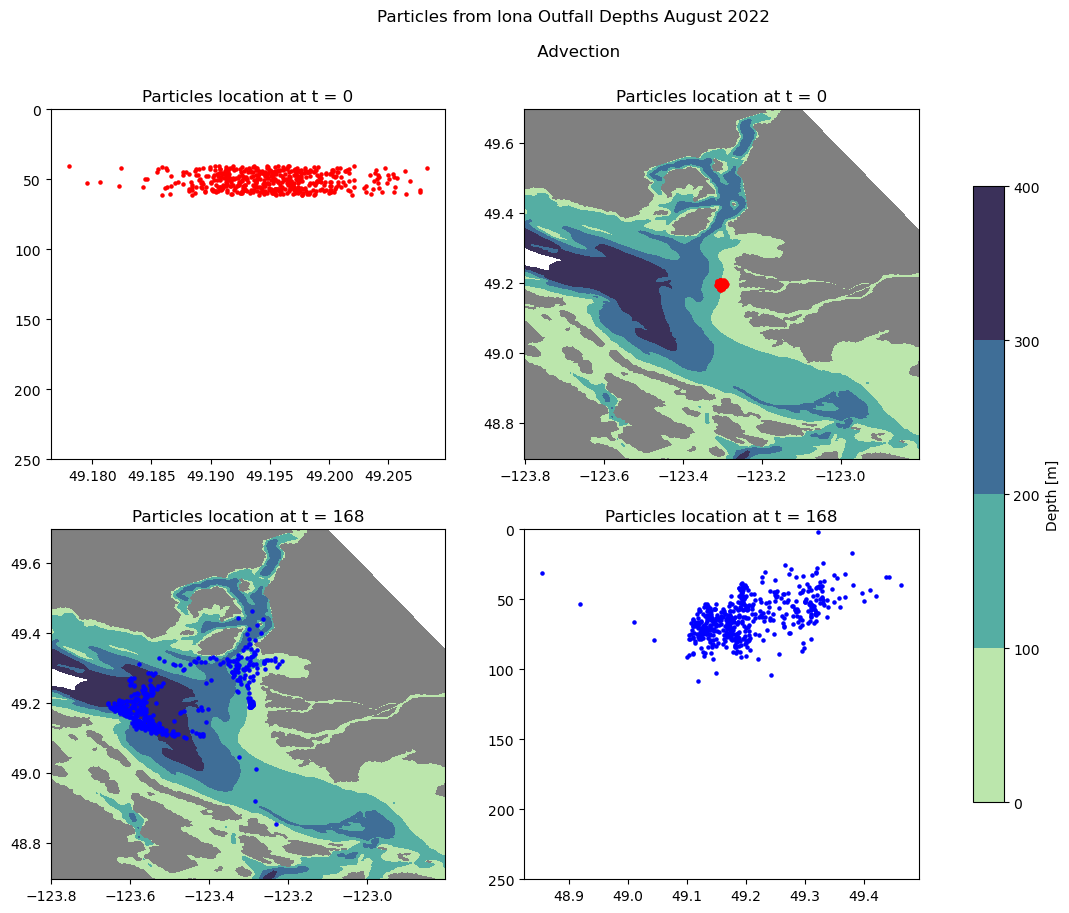

In [52]:
fig,axs=plt.subplots(2,2,figsize=(14,10))

axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c='r',s=5)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = {length*24}')

axs[1,1].scatter(ds1.lat[:,-1],depth1[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.suptitle('Particles from Iona Outfall Depths August 2022 \n \n Advection')

In [53]:
pset_adv_mix.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,export,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset_adv_mix.ParticleFile(name=outfile_adv_mix, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking/Advection_Mixing_20220823_1n_20220830_1n.zarr.
  4%|▎         | 21600.0/604800.0 [00:31<13:08, 740.03it/s]

100%|██████████| 604800.0/604800.0 [12:06<00:00, 832.74it/s] 


In [54]:
ds1 = xr.open_zarr(outfile_adv_mix)
depth1 = ds1.z*ds1.fact

Text(0.5, 0.98, 'Particles from Iona Outfall Depths August 2022 \n \n Advection + Mixing')

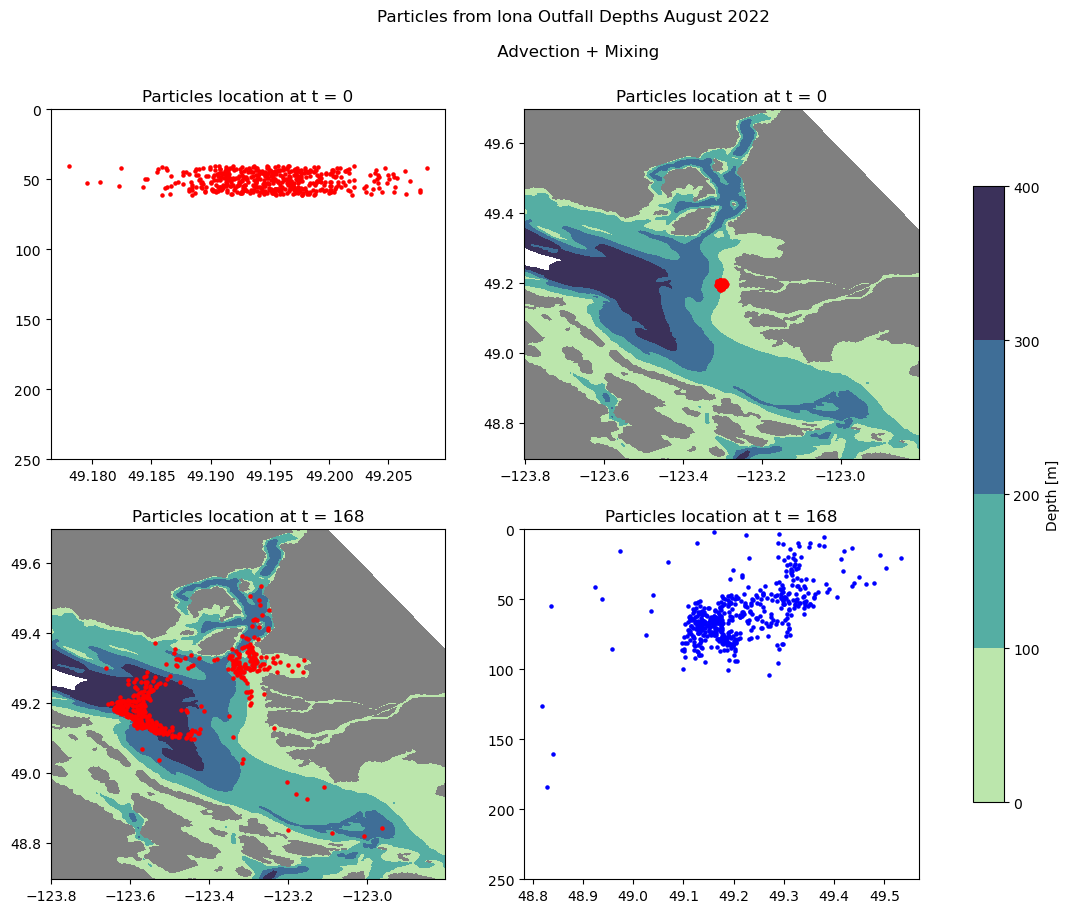

In [55]:
fig,axs=plt.subplots(2,2,figsize=(14,10))

axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c='r',s=5)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))
#axs[0,0].errorbar(ds1.lat.mean(dim='trajectory')[0], depth1.mean(dim='trajectory')[0], xerr= ds1.lat.std(dim='trajectory')[0], yerr= depth1.std(dim='trajectory')[0],zorder=5,c='k')

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='r',s=5)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = {length*24}')
#axs[1,0].errorbar(ds1.lon.mean(dim='trajectory')[-1], ds1.lat.mean(dim='trajectory')[-1], yerr= ds1.lat.std(dim='trajectory')[-1], xerr= ds1.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds1.lat[:,-1],depth1[:,-1],zorder=3,c='b',s=5)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))
#axs[1,1].errorbar(ds1.lat.mean(dim='trajectory')[-1], depth1.mean(dim='trajectory')[-1], xerr= ds1.lat.std(dim='trajectory')[-1], yerr= depth1.std(dim='trajectory')[-1],zorder=5,c='k')
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.suptitle('Particles from Iona Outfall Depths August 2022 \n \n Advection + Mixing')

Runs for PBDEs and different sinking rates

In [56]:
pset_sewage.execute([Advection,turb_mix,Displacement,Sinking_sewage,CheckOutOfBounds,export,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset_sewage.ParticleFile(name=outfile_sewage, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking/Run_sewage_20220823_1n_20220830_1n.zarr.
  2%|▏         | 12600.0/604800.0 [00:17<10:00, 986.35it/s]

100%|██████████| 604800.0/604800.0 [11:27<00:00, 879.50it/s] 


In [57]:
pset_marine.execute([Advection,turb_mix,Displacement,Sinking_marine,CheckOutOfBounds,export,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset_marine.ParticleFile(name=outfile_marine, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking/Run_marine_20220823_1n_20220830_1n.zarr.
  6%|▋         | 37800.0/604800.0 [00:43<08:51, 1067.55it/s]

100%|██████████| 604800.0/604800.0 [11:24<00:00, 883.59it/s] 


In [58]:
ds_s = xr.open_zarr(outfile_sewage)
depth_s = ds_s.z*ds_s.fact
#
ds_m = xr.open_zarr(outfile_marine)
depth_m = ds_m.z*ds_m.fact

Text(0.5, 0.98, 'Sewage and Marine Particles August 2022 \n \n Advection + Mixing + Sinking')

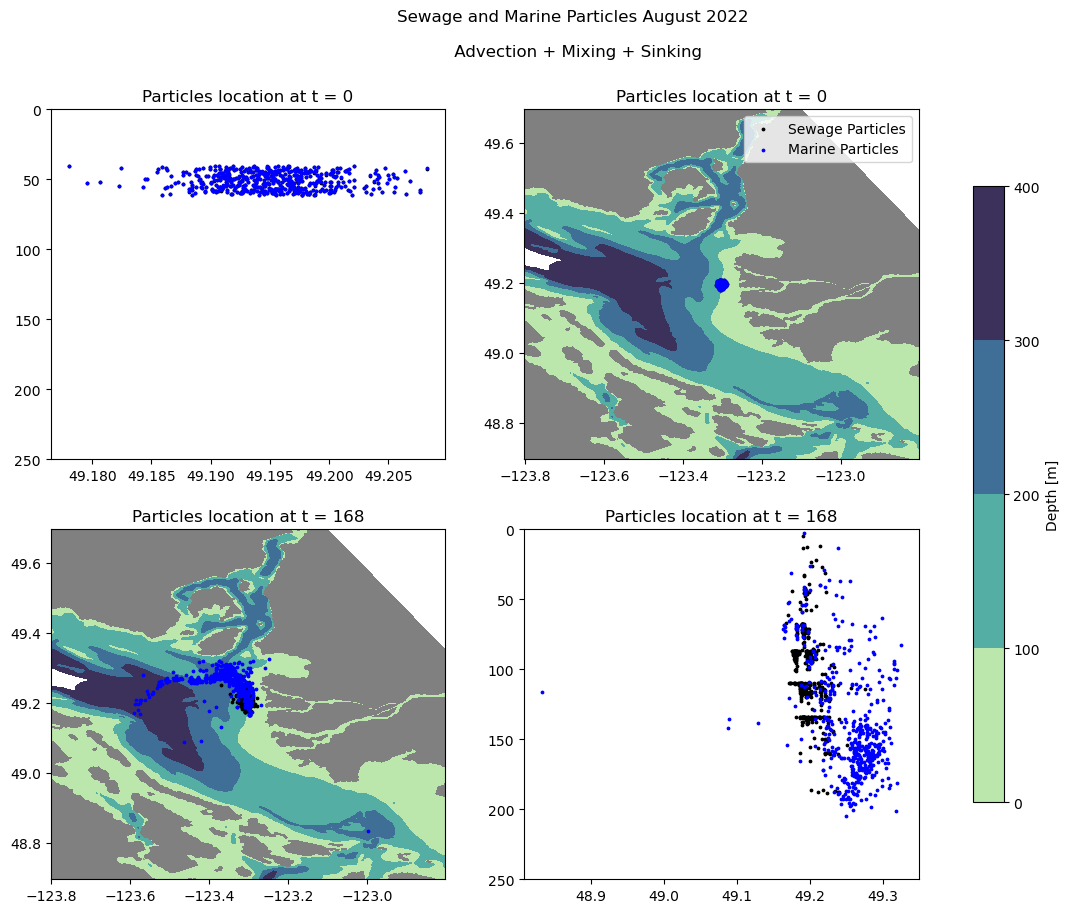

In [59]:
fig,axs=plt.subplots(2,2,figsize=(14,10))

axs[0,0].scatter(ds_s.lat[:,0],depth_s[:,0],zorder=3,c='k',s=3)
axs[0,0].scatter(ds_m.lat[:,0],depth_m[:,0],zorder=3,c='b',s=3)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds_s.time['obs'].values[0]))
#axs[0,0].errorbar(ds1.lat.mean(dim='trajectory')[0], depth1.mean(dim='trajectory')[0], xerr= ds1.lat.std(dim='trajectory')[0], yerr= depth1.std(dim='trajectory')[0],zorder=5,c='k')

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds_s.lon[:,0],ds_s.lat[:,0],zorder=3,c='k',s=3, label = 'Sewage Particles')
axs[0,1].scatter(ds_m.lon[:,0],ds_m.lat[:,0],zorder=3,c='b',s=3, label = 'Marine Particles')
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title('Particles location at t = 0')
axs[0,1].legend()


im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds_s.lon[:,-1],ds_s.lat[:,-1],zorder=3,c='k',s=3)
axs[1,0].scatter(ds_m.lon[:,-1],ds_m.lat[:,-1],zorder=3,c='b',s=3)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = {length*24}')
#axs[1,0].errorbar(ds1.lon.mean(dim='trajectory')[-1], ds1.lat.mean(dim='trajectory')[-1], yerr= ds1.lat.std(dim='trajectory')[-1], xerr= ds1.lon.std(dim='trajectory')[-1],zorder=5,c='k')

axs[1,1].scatter(ds_s.lat[:,-1],depth_s[:,-1],zorder=3,c='k',s=3)
axs[1,1].scatter(ds_m.lat[:,-1],depth_m[:,-1],zorder=3,c='b',s=3)
axs[1,1].set_ylim([250,0])
#axs[1,1].set_xlim([-125,-123])
axs[1,1].set_title(f'Particles location at t = {length*24}')
#axs[1,1].errorbar(ds1.lat.mean(dim='trajectory')[-1], depth1.mean(dim='trajectory')[-1], xerr= ds1.lat.std(dim='trajectory')[-1], yerr= depth1.std(dim='trajectory')[-1],zorder=5,c='k')
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.suptitle('Sewage and Marine Particles August 2022 \n \n Advection + Mixing + Sinking')

ANIMATION

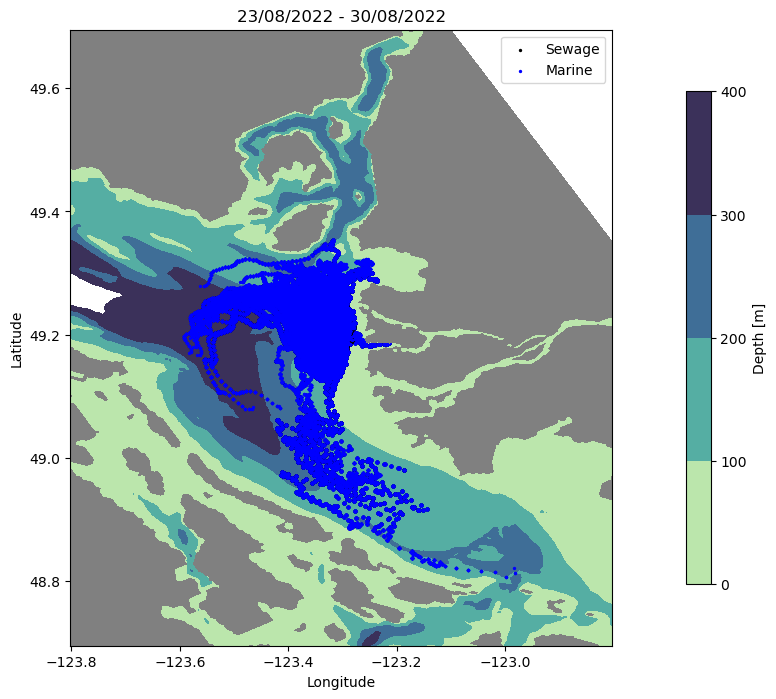

In [60]:
fig, ax = plt.subplots(figsize=(19, 8))
im = ax.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax.scatter(ds_s.lon[:, 0], ds_s.lat[:, 0],s=2, c='k', label = 'Sewage')
ax.scatter(ds_m.lon[:, 0], ds_m.lat[:, 0],s=2, c='b', label = 'Marine')
ax.legend()
ax.set_ylim([clat[0]-.5,clat[0]+.5])
ax.set_xlim([clon[0]-.5,clon[0]+.5])
ax.set_aspect(5/4.4)
nmin, nmax = 0, -1
#
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles_SM', artist='Vicente',
                comment='Particles movement (August 23-30, 2022)')
writer = FFMpegWriter(fps=10, metadata=metadata)

with writer.saving(fig, "Sewage_Marine_Particles.mp4", 100):
    for tm in range(len(ds_s.obs)):
        s = ax.scatter(ds_s.lon[:, nmin:tm], ds_s.lat[:, nmin:tm],s=2, c='k')
        m = ax.scatter(ds_m.lon[:, nmin:tm], ds_m.lat[:, nmin:tm],s=2, c='b')        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('23/08/2022 - 30/08/2022')
        writer.grab_frame()

Difference between Sewage and Marine particles are based on their sinking rates; sewage particles sink faster than marine particles. On the other hand , we need to add a absorption and desorption rate constants for each congener into both types of particles.